In [1]:
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df1 = pd.read_csv('task_demand_1.csv')

df = dataset = df1.copy()
df['SETTLEMENTDATE'] = pd.to_datetime(df.SETTLEMENTDATE,format='%m/%d/%Y %H:%M')
df=df.set_index('SETTLEMENTDATE',drop=True)

dataset['SETTLEMENTDATE'] = pd.to_datetime(dataset.SETTLEMENTDATE,format='%m/%d/%Y %H:%M')
dataset=dataset.set_index('SETTLEMENTDATE',drop=True)
#print the head
# df.tail()
dataset.tail()

,RRP,TOTALDEMAND
SETTLEMENTDATE,,
2018-11-01 17:00:00,113.86,1873.53
2018-11-01 17:30:00,110.18,1889.06
2018-11-01 18:00:00,115.45,1924.57
2018-11-01 18:30:00,116.55,2014.13
2018-11-01 19:00:00,177.82,1980.02


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



predict_days = 48
report_dict = {}
symbol = "EL_trial"
forcastdays = predict_days
testingflag=0
test_size=0.3
def data_preprocessing(dataset):   #Total 10 rows in dataset
    """take filtered dataframe and returns
    regressor,X_train, X_test, y_train, y_test, forcast_ip_scaled, header
    """

    if testingflag:
        DF = dataset.iloc[:-predict_days,:]    # i.e (10-1) if predict days =1 i.e total 1 to 9 rows
    else:
        DF = dataset.copy()
        
    target = DF.iloc[predict_days:, 1]  # target will be from 2 to 9 Close  # implement method to get label from file
    input = DF.iloc[:-predict_days, 0]    # input will be from 1 to 8

    
    # feature scaling
    # Note length of scaling dataframe should be same otherwise need to use separate scaling objects.
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_target = MinMaxScaler(feature_range=(0, 1))
    DF_scaled = sc.fit_transform(DF[['RRP','TOTALDEMAND']])  # This is total dataset rows will be 1 to 9
    input_scaled = DF_scaled[:-predict_days]       # Row from 1 to 8
    target_scaled = sc_target.fit_transform(target.reshape(-1,1))  # This is total dataset rows will be 1 to 9

    forcast_ip_scaled = DF_scaled[-predict_days:]  #This is row no 9
    
    ### Split Data set as per test size.
    
    splitcount = int(input_scaled.shape[0] * test_size)  # +1
    print(splitcount)
    ##############

#     #Manual Split
# #     df_scaled_shape=df_scaled.shape[0]
#     X_train=input_scaled[:-splitcount,:]
#     X_test=input_scaled[-splitcount:,:]
#     #X_test_df=df_total.iloc[-(self.predict_days+splitcount):-self.predict_days,:]
#     y_train=target_scaled[:-splitcount,:]
#     y_test=target_scaled[-splitcount:,:]
#     ################


    # Creating data sctructure for test and training
    X_train, X_test, y_train, y_test = train_test_split(input_scaled, target_scaled, test_size=test_size)
    X_train, y_train = np.array(X_train), np.array(y_train)

    print("X_train.shape, X_test.shape, y_train.shape, y_test.shape, input_scaled.shape, target_scaled.shape, forcast_ip_scaled.shape,DF.shape")
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, input_scaled.shape, target_scaled.shape, forcast_ip_scaled.shape,DF.shape)

     # For testing purpose
    test_DF = DF_scaled[-(X_test.shape[0]+48+48):-(48+48),:]
    
    ###Create Header
    # create report header
    header = symbol + "-" + str(predict_days) 
    return X_train, X_test, y_train, y_test, forcast_ip_scaled,test_DF, header, sc,sc_target





In [5]:
def buildModel(X_train, X_test, y_train, y_test, forcast_scaled, method):
    """
    Build final model for predicting real testing data
    """

    if method == 'RNN':
        regressor, MSE, X_train, X_test, y_train, y_test, forcast_scaled= performRNNlass(X_train, X_test, y_train, y_test, forcast_scaled)
        print(method,MSE)
        return regressor,MSE,X_train, X_test, y_train, y_test,forcast_scaled

In [6]:
def performRNNlass(X_train, X_test, y_train, y_test, forcast_scaled):

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    forcast_scaled = np.reshape(forcast_scaled, (forcast_scaled.shape[0], forcast_scaled.shape[1], 1))
    
    
    
    regressor= Sequential()

    LSTM_units = 50
    LSTM_unit_increment = 30
    dropoutunit = 0.2
    epochs=1000
    batch_size=1

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    regressor.add(Dropout(dropoutunit))

    LSTM_units = 50
    LSTM_units = LSTM_units + LSTM_unit_increment

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units=LSTM_units, return_sequences=True))
    regressor.add(Dropout(dropoutunit))

    # Adding a third LSTM layer and some Dropout regularisation
    LSTM_units = LSTM_units + LSTM_unit_increment
    regressor.add(LSTM(units=LSTM_units, return_sequences=True))
    regressor.add(Dropout(dropoutunit))
    
    
    # Adding a fourth LSTM layer and some Dropout regularisation
    LSTM_units = LSTM_units + LSTM_unit_increment
    regressor.add(LSTM(units=LSTM_units))
    regressor.add(Dropout(dropoutunit))

    # print(X_train.shape,y_train.shape)
    # Adding the output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    print('rnn model build',X_test.shape)


    score = regressor.evaluate(X_test, y_test, batch_size=1, verbose=2)
    return regressor,score,X_train, X_test, y_train, y_test,forcast_scaled

In [7]:
import numpy as np

from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
# from sklearn import neighbors
# from sklearn import svm
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test, forcast_ip_scaled, test_DF, header,sc,sc_target = data_preprocessing(dataset)
regressor,score,X_train, X_test, y_train, y_test,forcast_scaled = buildModel(X_train, X_test, y_train, y_test, forcast_ip_scaled, 'RNN')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


285
X_train.shape, X_test.shape, y_train.shape, y_test.shape, input_scaled.shape, target_scaled.shape, forcast_ip_scaled.shape,DF.shape
(666, 2) (286, 2) (666, 1) (286, 1) (952, 2) (952, 1) (48, 2) (1000, 2)
Epoch 1/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0285
Epoch 2/1000
666/666 [==============================] - 11s 16ms/step - loss: 0.0190
Epoch 3/1000
666/666 [==============================] - 11s 16ms/step - loss: 0.0157
Epoch 4/1000
666/666 [==============================] - 11s 16ms/step - loss: 0.0136
Epoch 5/1000
666/666 [==============================] - 11s 17ms/step - loss: 0.0133
Epoch 6/1000
666/666 [==============================] - 11s 17ms/step - loss: 0.0132
Epoch 7/1000
666/666 [==============================] - 11s 16ms/step - loss: 0.0142
Epoch 8/1000
666/666 [==============================] - 11s 16ms/step - loss: 0.0137
Epoch 9/1000
666/666 [==============================] - 11s 17ms/step - loss: 0.0132
Epoch 10/1000
666/666 [====

666/666 [==============================] - 14s 22ms/step - loss: 0.0112
Epoch 94/1000
666/666 [==============================] - 15s 22ms/step - loss: 0.0111
Epoch 95/1000
666/666 [==============================] - 15s 23ms/step - loss: 0.0115
Epoch 96/1000
666/666 [==============================] - 15s 23ms/step - loss: 0.0112
Epoch 97/1000
666/666 [==============================] - 15s 22ms/step - loss: 0.0112
Epoch 98/1000
666/666 [==============================] - 15s 23ms/step - loss: 0.0115
Epoch 99/1000
666/666 [==============================] - 15s 22ms/step - loss: 0.0113
Epoch 100/1000
666/666 [==============================] - 15s 22ms/step - loss: 0.0113
Epoch 101/1000
666/666 [==============================] - 15s 22ms/step - loss: 0.0112
Epoch 102/1000
666/666 [==============================] - 15s 23ms/step - loss: 0.0115
Epoch 103/1000
666/666 [==============================] - 15s 23ms/step - loss: 0.0114
Epoch 104/1000
666/666 [==============================] - 18s 27

666/666 [==============================] - 14s 21ms/step - loss: 0.0111
Epoch 188/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0109
Epoch 189/1000
666/666 [==============================] - 15s 22ms/step - loss: 0.0108
Epoch 190/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0113
Epoch 191/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0110
Epoch 192/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0109
Epoch 193/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0108
Epoch 194/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0108
Epoch 195/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0113
Epoch 196/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0110
Epoch 197/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0111
Epoch 198/1000
666/666 [==============================] - 

666/666 [==============================] - 13s 20ms/step - loss: 0.0106
Epoch 282/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0108
Epoch 283/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0108
Epoch 284/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0111
Epoch 285/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0108
Epoch 286/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0107
Epoch 287/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0107
Epoch 288/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0110
Epoch 289/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0109
Epoch 290/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0107
Epoch 291/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0107
Epoch 292/1000
666/666 [==============================] - 

666/666 [==============================] - 12s 19ms/step - loss: 0.0104
Epoch 376/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0105
Epoch 377/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0109
Epoch 378/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0106
Epoch 379/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0104
Epoch 380/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0105
Epoch 381/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0107
Epoch 382/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0105
Epoch 383/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0104
Epoch 384/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0107
Epoch 385/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0105
Epoch 386/1000
666/666 [==============================] - 

666/666 [==============================] - 12s 19ms/step - loss: 0.0104
Epoch 470/1000
666/666 [==============================] - 12s 18ms/step - loss: 0.0103
Epoch 471/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0102
Epoch 472/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0107
Epoch 473/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0105
Epoch 474/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0105
Epoch 475/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0103
Epoch 476/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0106
Epoch 477/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0107
Epoch 478/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0101
Epoch 479/1000
666/666 [==============================] - 12s 19ms/step - loss: 0.0101
Epoch 480/1000
666/666 [==============================] - 

666/666 [==============================] - 14s 20ms/step - loss: 0.0102
Epoch 564/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0104
Epoch 565/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0104
Epoch 566/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0104
Epoch 567/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0102
Epoch 568/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0103
Epoch 569/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0104
Epoch 570/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0106
Epoch 571/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0103
Epoch 572/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0102
Epoch 573/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0101
Epoch 574/1000
666/666 [==============================] - 

666/666 [==============================] - 14s 20ms/step - loss: 0.0103
Epoch 658/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0101
Epoch 659/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0103
Epoch 660/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0101
Epoch 661/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0107
Epoch 662/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0104
Epoch 663/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0102
Epoch 664/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0102
Epoch 665/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0103
Epoch 666/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0103
Epoch 667/1000
666/666 [==============================] - 14s 21ms/step - loss: 0.0102
Epoch 668/1000
666/666 [==============================] - 

666/666 [==============================] - 13s 20ms/step - loss: 0.0101
Epoch 752/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0101
Epoch 753/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0101
Epoch 754/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0101
Epoch 755/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0102
Epoch 756/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0100
Epoch 757/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0099
Epoch 758/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0102
Epoch 759/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0103
Epoch 760/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0100
Epoch 761/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0102
Epoch 762/1000
666/666 [==============================] - 

666/666 [==============================] - 13s 19ms/step - loss: 0.0100
Epoch 846/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0102
Epoch 847/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0101
Epoch 848/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0100
Epoch 849/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0103
Epoch 850/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0097
Epoch 851/1000
666/666 [==============================] - 13s 19ms/step - loss: 0.0099
Epoch 852/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0098
Epoch 853/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0101
Epoch 854/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0102
Epoch 855/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0100
Epoch 856/1000
666/666 [==============================] - 

666/666 [==============================] - 13s 19ms/step - loss: 0.0101
Epoch 940/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0099
Epoch 941/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0107
Epoch 942/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0103
Epoch 943/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0098
Epoch 944/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0097
Epoch 945/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0100
Epoch 946/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0101
Epoch 947/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0101
Epoch 948/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0099
Epoch 949/1000
666/666 [==============================] - 13s 20ms/step - loss: 0.0100
Epoch 950/1000
666/666 [==============================] - 

In [ ]:
# from matplotlib import pyplot

# history = regressor.fit(X_train, y_train, epochs=30, validation_split=0.3)
# pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['val_loss'])
# pyplot.title('model train vs validation loss -> Shows efficieny of model')
# pyplot.ylabel('loss')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper right')
# pyplot.show()

In [8]:
# DF,sc,sc_y,target_testDF,regressor,  X_train, X_test, y_train, y_test, forcast_ip_scaled, header,report_dict
from sklearn.metrics import mean_squared_error
from math import sqrt

predicted_demand = regressor.predict(X_test)    #This should be from row no 2 to 9
predicted_demand = sc_target.inverse_transform(predicted_demand).round(2)
y_orignal = sc_target.inverse_transform(y_test).round(2)


testtraindf = pd.DataFrame()
testtraindf['y_orignal']=pd.Series(y_orignal.reshape(y_orignal.shape[0]))
testtraindf['y_predicted']=pd.Series(predicted_demand.reshape(predicted_demand.shape[0]))


rmse = sqrt(mean_squared_error(y_orignal, predicted_demand))
print('RMSE for Test vs Orignal: %.3f' % rmse)

RMSE for Test vs Orignal: 148.249


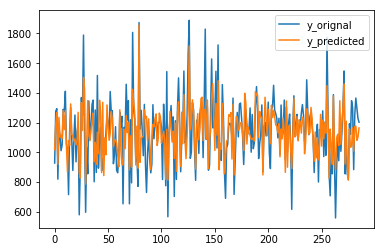

In [9]:
testtraindf.plot()


In [10]:
#     test_DF = dataset.iloc[-(X_test.shape[0]+48):-48,1]
testDemand = regressor.predict(test_DF.reshape(test_DF.shape[0],test_DF.shape[1],1))              
testDemand = sc_target.inverse_transform(testDemand).round(2)
rmse = sqrt(mean_squared_error(dataset.iloc[-(X_test.shape[0]+48):-48,1], testDemand))
print('RMSE for last 286 steps : %.3f' % rmse)



RMSE for last 286 steps : 116.282


                     TOTALDEMAND   testDemand
SETTLEMENTDATE                               
2018-10-31 17:00:00      1758.11  1382.849976
2018-10-31 17:30:00      1775.01  1458.020020
2018-10-31 18:00:00      1814.23  1568.599976
2018-10-31 18:30:00      1856.09  1506.290039
2018-10-31 19:00:00      1829.48  1287.239990


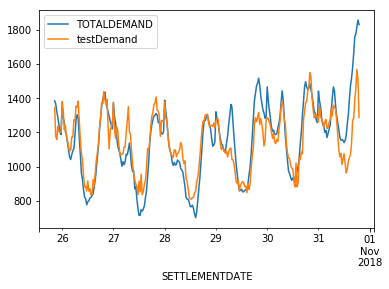

In [11]:
# Get future n dates for forcased values
def get_dates(duration,basedate):
    from datetime import datetime
    date =  basedate
    dates = pd.DataFrame(index=pd.date_range(date, periods=duration+1, freq='1800s')).iloc[1:,:]
    return dates

result = pd.DataFrame()
result = pd.concat([result, dataset.iloc[-(X_test.shape[0]+48):-48,1]], axis=1)
result['testDemand'] = testDemand

print(result.tail())
result.plot()

                     forcastedDemand
SETTLEMENTDATE                      
2018-11-01 17:00:00      1665.040039
2018-11-01 17:30:00      1679.079956
2018-11-01 18:00:00      1667.869995
2018-11-01 18:30:00      1679.420044
2018-11-01 19:00:00      1939.900024


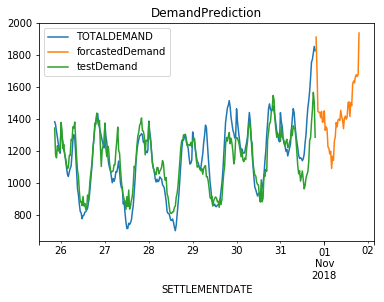

In [14]:
forcast_demand = regressor.predict(forcast_ip_scaled.reshape(48,2,1))     #This should give row no 10 for 9th row input

forcast_demand = sc_target.inverse_transform(forcast_demand).round(2)  #This should give row no 10

fs_df = get_dates(48,result.index[-1])
fs_df['forcastedDemand'] = forcast_demand.round(2)
fs_df.index.names = ['SETTLEMENTDATE']
print(fs_df.tail())
result = pd.concat([result,fs_df])
result.plot(legend=True, title='DemandPrediction')

In [15]:
result.to_csv('result2.csv')
